# Assignment 2 - CIC-1205

## Exercise 6 - Clustering

Student: Balthazar Paixão


In [49]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pickle

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier, export_text

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [50]:
SEED=57

def transform_array(arr: np.ndarray) -> list:
    """
    •0 → NONE
    •(0, 5] → WEAK
    •(5, 25] → MODERATE
    •(25,50] → STRONG
    •(50, ∞] → EXTREME
    """
    arr = arr.tolist()
    for i in range(len(arr)):
        if arr[i][0] == 0:
            arr[i] = 0  # 'NONE'
        elif arr[i][0] > 0 and arr[i][0] <= 5:
            arr[i] = 1  # 'WEAK'
        elif arr[i][0] > 5 and arr[i][0] <= 25:
            arr[i] = 2  # 'MODERATE'
        elif arr[i][0] > 25 and arr[i][0] <= 50:
            arr[i] = 3  # 'STRONG'
        elif arr[i][0] > 50:
            arr[i] = 4  # 'EXTREME'
    return arr


def count_values_list(lst: list) -> dict:
    """
    Count the number of times each value appears in a list
    """
    dict_counter = {}
    for i in lst:
        dict_counter[i] = dict_counter.get(i, 0) + 1

    return dict_counter

In [51]:
pickle_file = "../class-repo/cic1205/data/atmoseer/A652.pickle"

with open(pickle_file, "rb") as f:
    (X_train, y_train,
     X_val, y_val,
     X_test, y_test) = pickle.load(f)

In [52]:
y_train = transform_array(y_train)
print(f"y_train: {count_values_list(y_train)}")
y_val = transform_array(y_val)
print(f"y_val:   {count_values_list(y_val)}")
y_test = transform_array(y_test)
print(f"y_test:  {count_values_list(y_test)}")

y_train: {0: 9258, 2: 88, 1: 664, 3: 2}
y_val:   {0: 2277, 1: 222, 3: 1, 2: 6}
y_test:  {0: 8769, 1: 757, 2: 50, 4: 2, 3: 4}


In [53]:
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## K Means


In [54]:
params = {
    'n_clusters': [3, 4, 5],
    'max_iter': [100, 200],
    'tol': [0.0001, 0.001],
    'n_init': [10, 20]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
kmeans = KMeans(random_state=SEED)

grid_search = GridSearchCV(kmeans, params, scoring='f1_macro', cv=skf, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_iter': 100, 'n_clusters': 3, 'n_init': 10, 'tol': 0.0001}
0.1733319729851612
KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=57)


y_pred:  {2: 4617, 1: 4175, 0: 790}
y_test:  {0: 8769, 1: 757, 2: 50, 4: 2, 3: 4}


Text(0.5, 1.0, 'KMeans')

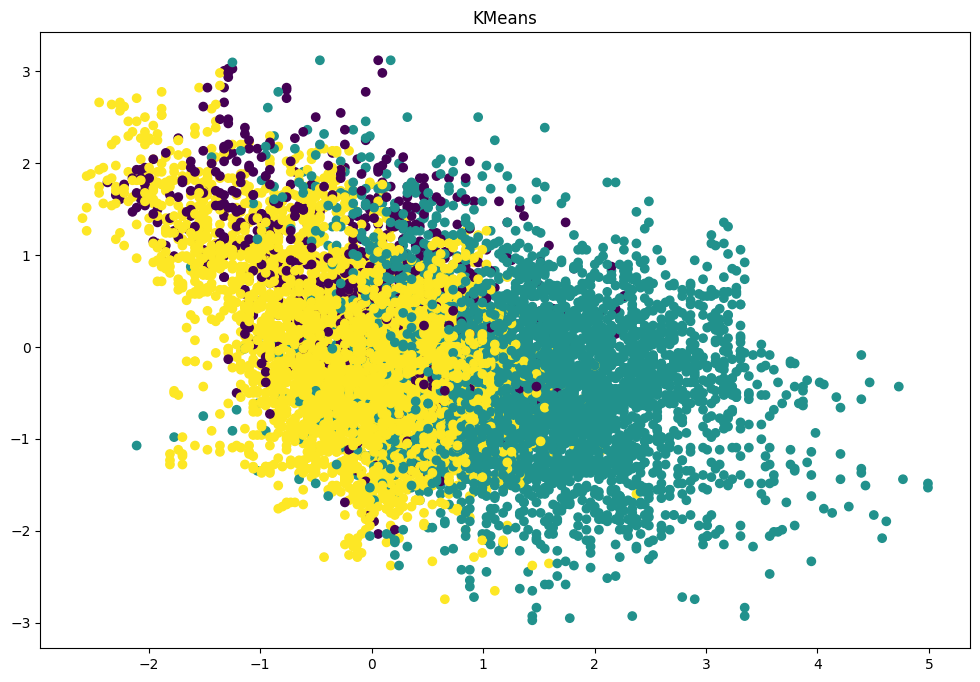

In [55]:
kmeans = KMeans(**grid_search.best_params_, random_state=SEED)
kmeans.fit(X_train, y_train)

y_pred = kmeans.predict(X_test)

print(f"y_pred:  {count_values_list(y_pred)}")
print(f"y_test:  {count_values_list(y_test)}")

plt.figure(figsize=(12, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.title("KMeans")

## DB Scan


In [56]:
params = {
    'eps': [0.5, 1.0, 1.5],
    'min_samples': [5, 10, 15],
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

dbscan = DBSCAN()

grid_search = GridSearchCV(dbscan, params, cv=skf, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/balthapaixao/Desktop/baltha/projects/portfolio/MSc-codes/cic1205-machine-learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/balthapaixao/Desktop/baltha/projects/portfolio/MSc-codes/cic1205-machine-learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/balthapaixao/Desktop/baltha/projects/portfolio/MSc-codes/cic1205-machine-learning/.venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/balthapaixao/Desktop/baltha/projects/portfolio/MSc-codes/cic1205-machine-learning/.venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 353, in 

{'eps': 0.5, 'min_samples': 5}
nan
DBSCAN()


y_pred:  {-1: 9582}
y_test:  {0: 8769, 1: 757, 2: 50, 4: 2, 3: 4}


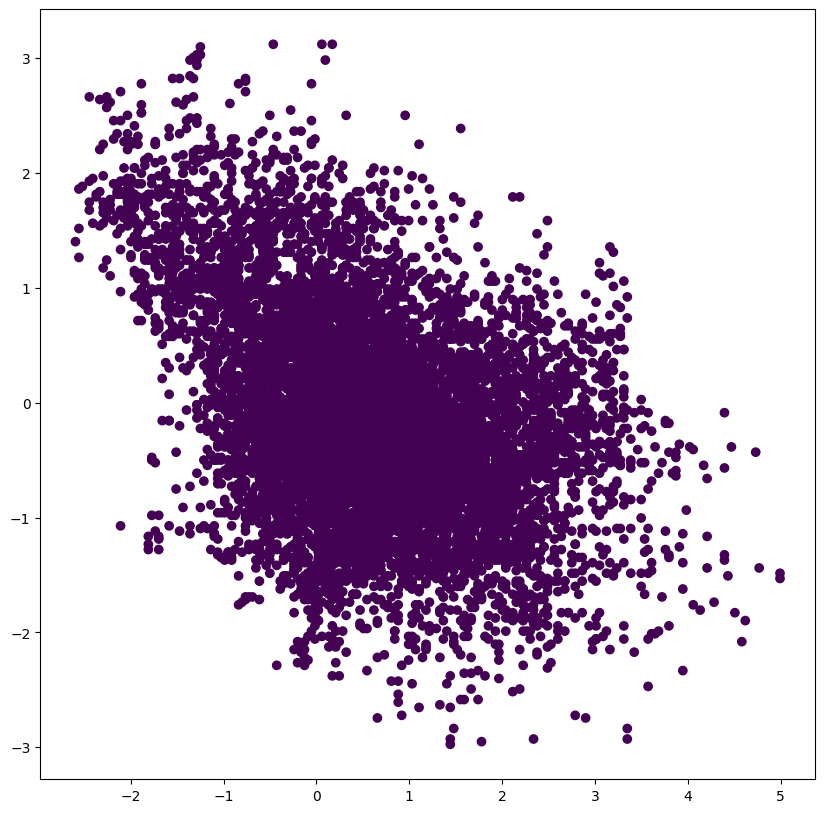

In [57]:
DB = DBSCAN(**grid_search.best_params_)
DB.fit(X_train, y_train)

y_pred = DB.fit_predict(X_test)
print(f"y_pred:  {count_values_list(y_pred)}")
print(f"y_test:  {count_values_list(y_test)}")

#plot groups
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.show()

## Decision Tree

In [59]:
params = {
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [ 3, 4, 5],
    'max_features': [3, 4, 5]
}

X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

DT = DecisionTreeClassifier(random_state=SEED)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_search = GridSearchCV(DT, params, scoring='f1_macro', cv=skf, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [60]:
DT = DecisionTreeClassifier(**grid_search.best_params_, random_state=SEED)

DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features=4, min_samples_leaf=3,
                       random_state=57)

In [61]:
text_representation = export_text(DT)
print(text_representation)

|--- feature_12 <= 3.29
|   |--- feature_18 <= 0.94
|   |   |--- feature_7 <= 0.00
|   |   |   |--- class: 0
|   |   |--- feature_7 >  0.00
|   |   |   |--- class: 0
|   |--- feature_18 >  0.94
|   |   |--- feature_7 <= 0.00
|   |   |   |--- class: 0
|   |   |--- feature_7 >  0.00
|   |   |   |--- class: 1
|--- feature_12 >  3.29
|   |--- feature_20 <= 4.88
|   |   |--- feature_6 <= -0.18
|   |   |   |--- class: 0
|   |   |--- feature_6 >  -0.18
|   |   |   |--- class: 0
|   |--- feature_20 >  4.88
|   |   |--- feature_10 <= 1.02
|   |   |   |--- class: 0
|   |   |--- feature_10 >  1.02
|   |   |   |--- class: 1



y_pred:  {0: 9301, 1: 281}
y_test:  {0: 8769, 1: 757, 2: 50, 4: 2, 3: 4}


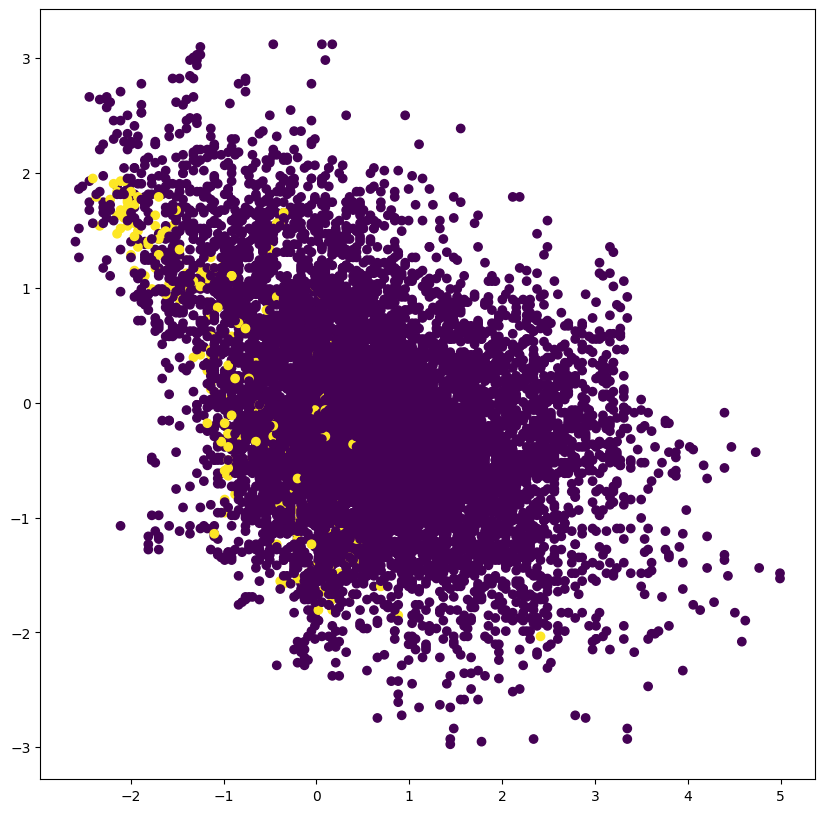

In [62]:
DT = DecisionTreeClassifier(**grid_search.best_params_, random_state=SEED)
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)
print(f"y_pred:  {count_values_list(y_pred)}")
print(f"y_test:  {count_values_list(y_test)}")

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.show()